In [7]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import datetime
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
#plot roc curve
from sklearn.metrics import roc_curve, auc
from scipy import interp

from models import BertClassifier, Dataset, init_defaults

In [2]:
RUN_ID ='bert-base-uncased-paragraphs-epochs5-lr1.00e-06-batch1-balanced-downsampling-seed42-20230623-202931'
MODEL_PATH = f'../models/{RUN_ID}'

BASE_MODEL = 'bert-base-uncased'

# Load the trained data
df_train = pd.read_csv(f'{MODEL_PATH}/train.csv')
df_test = pd.read_csv(f'{MODEL_PATH}/test.csv')
df_val = pd.read_csv(f'{MODEL_PATH}/val.csv')

df = pd.read_csv(f'{MODEL_PATH}/df.csv')

# Load the model
tokenizer, authors, author2idx, idx2author, model = init_defaults(df, BASE_MODEL)
model = BertClassifier()
model.load_state_dict(torch.load(f'{MODEL_PATH}/model_4.pt'))


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [5]:
def eval(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)

    use_cuda = torch.cuda.is_available()
    #use_cuda = False
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    y_pred = []
    y_pred_prob = []
    y_true = []
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            y_pred.append(output.argmax(dim=1).item())
            y_pred_prob.append(output.softmax(dim=1).squeeze(0).cpu().numpy())
            y_true.append(test_label.item())
              
    
    return y_pred, y_pred_prob, y_true

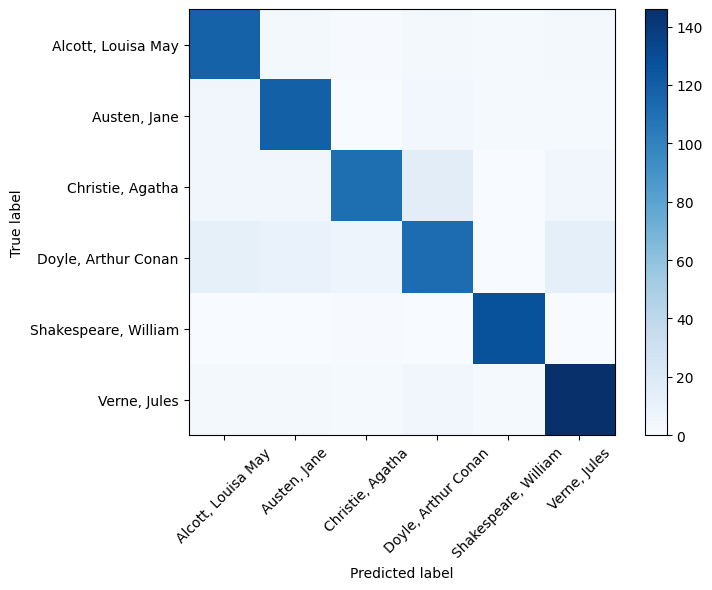

In [6]:

y_pred, y_pred_prob, y_true = eval(model, df_test)
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plot ticks
tick_marks = np.arange(len(authors))
plt.xticks(tick_marks, authors, rotation=45)
plt.yticks(tick_marks, authors)

plt.show()



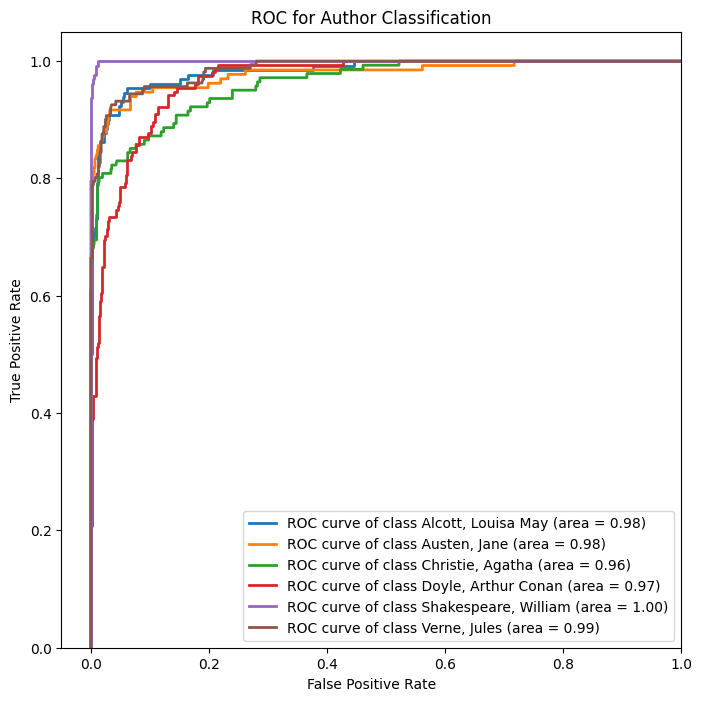

In [11]:

n_classes = len(authors)

classes = [i for i in range(n_classes)]

_, y_pred_prob, y_true = eval(model, df_test)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    _y_true = np.array(y_true) == i
    _y_true = _y_true.astype(int)
    _y_pred_prob = np.array(y_pred_prob)[:, i]
    fpr[i], tpr[i], _ = roc_curve(_y_true, _y_pred_prob)
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(8, 8))
lw = 2

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], "-", lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(authors[i], roc_auc[i]))

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Author Classification')
plt.legend(loc="lower right")
plt.show()


In [17]:
#plot accuracy, precision, recall and f1 score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


print("Test Metrics")
print('Accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
print('F1: {:.2f}'.format(f1_score(y_true, y_pred, average='macro')))

Test Metrics
Accuracy: 0.87
Precision: 0.87
Recall: 0.87
F1: 0.87


In [18]:
y_pred, y_pred_prob, y_true = eval(model, df_train)

print("Train Metrics")
print('Accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
print('F1: {:.2f}'.format(f1_score(y_true, y_pred, average='macro')))

Train Metrics
Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1: 0.99
